In [3]:
import numpy as np
import matplotlib.pyplot as pt
import scipy as ci
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

<font size=5>Problem 1<font>

In [42]:
def Start(start):
    ###################################################################
    # This file is week06_moon_shot.py. It creates a lot of png images 
    # of the solar system for use by iMovie (Mac) or Movie Maker (Windows).
    # George Gollin, University of Illinois, June 10, 2016
    # import libraries
    import week06_solarsystemObject as SSO
    import numpy as np
    ############# initialize stuff #############
    # Let's launch a space probe from low earth orbit intended to arrive at (or
    # at least pass near) the moon.
    # Our coordinate system is heliocentric: the sun is at the origin. I pretend
    # that all planets orbit in perfect circles in the same plane. The x and y
    # axes are defined with respect to the fixed stars. This means that we will need
    # to translate positions and velocities with respect to earth into quantities
    # with respect to the sun.
    # At my reference time t = 0 (April 1, 2016 00:00:00 GMT) the earth was a little
    # bit on the negative y side of the negative x axis.
    # instantiate the solar system!
    MySolarSystem = SSO.SolarSystem()
    # Let's launch our probe from orbit at a starting time (in seconds) of 0. This
    # will be the "knob" we will adjust since t = 0 and the parameters set below 
    # will put the space probe ahead of the moon as it crosses the lunar orbit.
    start_time = start
    # here's how you figure out where the planets are at a particular instant of 
    # time. xplanet_all and yplanet_all are arrays.
    xplanet_all, yplanet_all = MySolarSystem.get_planet_xy(start_time)
    # the x,y positions for the earth are stored in the 4th elements in the arrays
    xearth_now = xplanet_all[MySolarSystem.earth_index]
    yearth_now = yplanet_all[MySolarSystem.earth_index]
    # you can get the planets' velocities (in our heliocentric frame) the same way.
    # note the presence of the current time in the function call. 
    vxplanet_all, vyplanet_all = MySolarSystem.get_planet_vxvy(start_time)
    # x,y velocities for the earth right now are the 4th elements in the arrays. 
    vxearth_now = vxplanet_all[MySolarSystem.earth_index]
    vyearth_now = vyplanet_all[MySolarSystem.earth_index]
    # TLI is "Trans Lunar Injection." Apollo 11 left earth orbit with an initial speed 
    # of 35,570 feet per second (10,841.736 m/s) and an altitude of 177 nautical miles
    # (203.688 statute miles, or 327,804.157 meters). 
    # see http://history.nasa.gov/ap11fj/02earth-orbit-tli.htm.
    TLI_v0 = 10841.736
    TLI_altitude = 327804.157
    # angle for probe initial position relative to the earth and +x direction
    # when the TLI burn takes place. I picked this because it does what I want. 
    TLI_theta = 180. * np.pi / 180.
    # We will need to transform the earth-centric position and velocity to a 
    # heliocentric frame of reference. First convert TLI_altitude to distance from 
    # the center of the earth. Note how I picked the earth radius out of the array 
    # of planet radii.
    TLI_r0 = TLI_altitude + MySolarSystem.planet_radius[MySolarSystem.earth_index]
    # use this to calculate x, y offsets for probe from earth's center, then add
    # into it the earth's position relative to the sun.
    TLI_x0 = TLI_r0 * np.cos(TLI_theta) + xearth_now
    TLI_y0 = TLI_r0 * np.sin(TLI_theta) + yearth_now
    # also get the x, y velocity components in a helio-centric coordinate system.
    # (FYI: the earth orbits in a counterclockwise direction when seen from a vantage
    # point on the positive z axis.)
    TLI_vx0 = -TLI_v0 * np.sin(TLI_theta) + vxearth_now
    TLI_vy0 = TLI_v0 * np.cos(TLI_theta) + vyearth_now
    # now initialize the probe's position. 
    xprobe_now = TLI_x0
    yprobe_now = TLI_y0
    # set the initial velocity (m/s) too.
    vxprobe_now = TLI_vx0
    vyprobe_now = TLI_vy0
    # time interval between steps in our numerical integration, in seconds. 
    TLI_dt = 60
    # dt for use inside our loop:
    dt = TLI_dt
    # current time
    time_now = start_time
    # maximum total length in days of our space flight
    max_days_in_flight = 15
    # also calculate the maximum time in seconds.
    max_elapsed_time_in_flight = max_days_in_flight * 24 * 3600
    # we might not start at start_time = 0, which is April 1, 2016. Take this into
    # account here. Time is in seconds.
    flight_must_end_by_this_time = max_elapsed_time_in_flight + start_time
    # number of steps to calculate: one more step than a specific number of days of
    # simulated flight.
    max_steps_float = max_days_in_flight * 24 * 60 * (60 / TLI_dt) + 1 
    # now turn this into an integer. round up using the ceil ("ceiling") function.
    max_steps = int(np.ceil(max_steps_float))
    # preallocate storage for arrays we will use; initilize them to "not a number" 
    # (nan). this should save time over doing an append each time we want to add an 
    # element into the array.
    # xprobe, yprobe is probe position with respect to the sun.
    xprobe = np.array([np.nan] * max_steps)
    yprobe = np.array([np.nan] * max_steps)
    # now create arrays of x, y points for the earth, also filled with "nan." 
    xearth = np.array([np.nan] * max_steps)
    yearth = np.array([np.nan] * max_steps)
    # let's keep track of the probe's velocity with respect to the sun too.
    vxprobe = np.array([np.nan] * max_steps)
    vyprobe = np.array([np.nan] * max_steps)
    # in a later week we will try using dt's that can vary with circumstances so
    # add a couple more arrays to help with this.
    tprobe = np.array([np.nan] * max_steps)
    dtprobe = np.array([np.nan] * max_steps)
    # we don't want to draw an image of where the probe is every pass through the 
    # loop since that would slow us down too much. Let's limit the number of images 
    # here.
    max_images = 50
    steps_per_image = np.ceil(max_steps_float / max_images)
    # loop index variable
    index = 0
    # we don't want to have a zillion figure windows open, so set the following flag
    # to  True.
    close_previous_figure = True
    # do we want to stop the loop when we land (or crash) into a planet? If not,
    # the loop will pretend that all planets are point masses.
    stop_when_probe_lands = False
    ############# here's the loop #############
    while (index < max_steps) and (time_now <= flight_must_end_by_this_time):
        # insert current position into the existing probe position arrays.
        xprobe[index] = xprobe_now
        yprobe[index] = yprobe_now
        # do the same for the probe's velocity.
        vxprobe[index] = vxprobe_now
        vyprobe[index] = vyprobe_now
        # also store time and dt in arrays.
        tprobe[index] = time_now
        dtprobe[index] = dt
        # do the same for the earth's position.
        xearth[index] = xearth_now
        yearth[index] = yearth_now 
        # let's keep track of whether or not the probe has crashed into the surface
        # of something. The value returned by the class function call will be 
        # negative if we haven't hit anything. If non-negative it is the index 
        # number of what we hit. 0 is the sun, 1 is Mercury, 2 is Venus, 3 is Earth, 
        # etc. The moon is 10.      
        the_probe_has_landed = MySolarSystem.crash_landing(time_now, xprobe_now, \
        yprobe_now)    
        # do I want to draw the solar system? draw it when the modulus of index 
        # and steps_per_image is zero. 
        draw_the_solar_system = (index % steps_per_image == 0)
        # If we decide to break out of the loop when we land, rather than continuing
        # to loop, we might draw the solar system one last time. But only enable
        # this code if you are going to exit the loop, otherwise you'll draw a zillion
        # plots, one for each pass through the loop after a landing.
        draw_the_solar_system = draw_the_solar_system or \
        (the_probe_has_landed >= 0 and stop_when_probe_lands)
        # now draw it if we want to.
        if draw_the_solar_system:
            # figure out the probe's speed so we can put this number on the plot.
            # calculate it both with respect to the earth (useful for a moon shot)
            # and with respect to the sun (useful for a Mars shot).
            # get the earth's with respect to the x,y velocity for the earth right now:
            vxplanet_all, vyplanet_all = MySolarSystem.get_planet_vxvy(time_now)
            vxearth_now = vxplanet_all[MySolarSystem.earth_index]
            vyearth_now = vyplanet_all[MySolarSystem.earth_index]
            # now calculate the probe's speed with respect to the sun.
            speed_wrt_sun = np.sqrt(vxprobe_now**2 + vyprobe_now**2)   
            # now calculate the probe's speed with respect to the earth.
            speed_wrt_earth = np.sqrt((vxprobe_now - vxearth_now)**2 + \
            (vyprobe_now - vyearth_now)**2)   
            # calculate probe positions arrays referenced to the current earth position.
            # note that xprobe and xearth are arrays, but xearth_now is just a number.
            xprobe_wrt_moving_earth = xprobe - xearth + xearth_now
            yprobe_wrt_moving_earth = yprobe - yearth + yearth_now
            # the following uses the earth as the origin in showing the probe.
            # use it for a moon shot.
            MySolarSystem.draw_earth_centric(time_now, close_previous_figure, \
            xprobe_wrt_moving_earth, yprobe_wrt_moving_earth, speed_wrt_earth)
            # this drawing function plots a larger portion of the solar system.
            # MySolarSystem.draw_solar_system(time_now, close_previous_figure, xprobe, \
            # yprobe, speed_wrt_sun)
        # break out of the loop if the probe just landed and we don't want to 
        # continue adjusting pisition and velocity.
        if the_probe_has_landed >= 0 and stop_when_probe_lands:
            print("Probe landed: end loop at elapsed time ", time_now - start_time, \
            " seconds = ", (time_now - start_time)/(24*3600), " days" )
            break
        # now update probe position and velocity using the higher order integration
        # technique from last week. use the same variable names as last week to
        # avoid errors and confusion.
        # position components
        xn = xprobe_now
        yn = yprobe_now
        # velocity components...
        vxn = vxprobe_now
        vyn = vyprobe_now
        # time
        tn = time_now
        # calculate dxn, etc. Note the call to a class function that gives us
        # gravitational acceleration as a function of position with resect to the sun.
        dxn = vxn * dt
        dyn = vyn * dt
        dvxn, dvyn = MySolarSystem.accel(xn, yn, tn) * dt
        # update intermediate position, velocity, and time
        xn_half = xn + dxn / 2
        yn_half = yn + dyn / 2
        vxn_half = vxn + dvxn / 2
        vyn_half = vyn + dvyn / 2
        tn_half = tn + dt / 2
        # calculate improved dxn, etc. see the in-class material writeup.
        dxn_improved = vxn_half * dt
        dyn_improved = vyn_half * dt
        dvxn_improved, dvyn_improved = MySolarSystem.accel(xn_half, yn_half, tn_half) * dt
        # now update position and velocity.
        xn = xn + dxn_improved
        yn = yn + dyn_improved
        vxn = vxn + dvxn_improved
        vyn = vyn + dvyn_improved
        # time too...
        tn = tn + dt
        # now put this back into the variables I am using elsewhere...
        xprobe_now = xn
        yprobe_now = yn
        vxprobe_now = vxn
        vyprobe_now = vyn
        time_now = tn
        # update the x,y position for the earth right now:
        xplanet_all, yplanet_all = MySolarSystem.get_planet_xy(time_now)
        xearth_now = xplanet_all[MySolarSystem.earth_index]
        yearth_now = yplanet_all[MySolarSystem.earth_index]
        # update index 
        index = index + 1
        # end of loop. 
    # we have filled various arrays with indices running from 0 to index - 1.
    # now truncate them to have full lengths of index. This might be necessary
    # if we hit the maximum elapsed time in flight (due to changes in dt) before
    # we run out of array space.
    xprobe = np.resize(xprobe, index)
    yprobe = np.resize(yprobe, index)
    vxprobe = np.resize(vxprobe, index)
    vyprobe = np.resize(vyprobe, index)
    tprobe = np.resize(tprobe, index)
    dtprobe = np.resize(dtprobe, index)
    xearth = np.resize(xearth, index)
    yearth = np.resize(yearth, index)
    ############# all done! #############



Now instantiating the solar system.
planetary configuration for U.S. Central Time  Sun Apr  3 19:00:00 2016


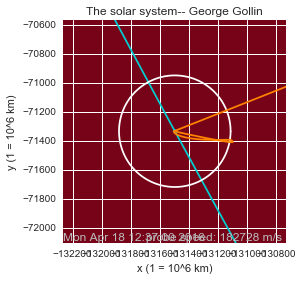

In [43]:
Start(86400*3)

Explaination: It's probably due to the fact that the attraction force is proportional to r^(-2). If the spaceship and Earth are too close in absolute distance (the initial program assumes Earth to be point mass), the force goes to infinity and a slingshot effect is generated, accelerating the spaceship enormously and diverting its direction. It looks like a bug in this plot but the following plot with a later launching time proves that Earth is indeed functioning as an accelerator and shooting the spaceship away as it gets too close.  


Now instantiating the solar system.
planetary configuration for U.S. Central Time  Sun Apr  3 23:48:00 2016


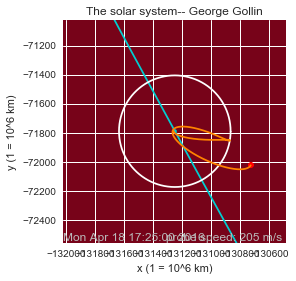

In [44]:
Start(86400*3.2)

<font size=5>Problem 2<font>

In [45]:
########## Storing velocities in list and then manipulate later
T=[]
Vx=[]
Vy=[]
def Start1(start):
    ###################################################################
    # This file is week06_moon_shot.py. It creates a lot of png images 
    # of the solar system for use by iMovie (Mac) or Movie Maker (Windows).
    # George Gollin, University of Illinois, June 10, 2016
    # import libraries
    import week06_solarsystemObject as SSO
    import numpy as np
    ############# initialize stuff #############
    # Let's launch a space probe from low earth orbit intended to arrive at (or
    # at least pass near) the moon.
    # Our coordinate system is heliocentric: the sun is at the origin. I pretend
    # that all planets orbit in perfect circles in the same plane. The x and y
    # axes are defined with respect to the fixed stars. This means that we will need
    # to translate positions and velocities with respect to earth into quantities
    # with respect to the sun.
    # At my reference time t = 0 (April 1, 2016 00:00:00 GMT) the earth was a little
    # bit on the negative y side of the negative x axis.
    # instantiate the solar system!
    MySolarSystem = SSO.SolarSystem()
    # Let's launch our probe from orbit at a starting time (in seconds) of 0. This
    # will be the "knob" we will adjust since t = 0 and the parameters set below 
    # will put the space probe ahead of the moon as it crosses the lunar orbit.
    start_time = start
    # here's how you figure out where the planets are at a particular instant of 
    # time. xplanet_all and yplanet_all are arrays.
    xplanet_all, yplanet_all = MySolarSystem.get_planet_xy(start_time)
    # the x,y positions for the earth are stored in the 4th elements in the arrays
    xearth_now = xplanet_all[MySolarSystem.earth_index]
    yearth_now = yplanet_all[MySolarSystem.earth_index]
    # you can get the planets' velocities (in our heliocentric frame) the same way.
    # note the presence of the current time in the function call. 
    vxplanet_all, vyplanet_all = MySolarSystem.get_planet_vxvy(start_time)
    # x,y velocities for the earth right now are the 4th elements in the arrays. 
    vxearth_now = vxplanet_all[MySolarSystem.earth_index]
    vyearth_now = vyplanet_all[MySolarSystem.earth_index]
    # TLI is "Trans Lunar Injection." Apollo 11 left earth orbit with an initial speed 
    # of 35,570 feet per second (10,841.736 m/s) and an altitude of 177 nautical miles
    # (203.688 statute miles, or 327,804.157 meters). 
    # see http://history.nasa.gov/ap11fj/02earth-orbit-tli.htm.
    TLI_v0 = 10841.736
    TLI_altitude = 327804.157
    # angle for probe initial position relative to the earth and +x direction
    # when the TLI burn takes place. I picked this because it does what I want. 
    TLI_theta = 180. * np.pi / 180.
    # We will need to transform the earth-centric position and velocity to a 
    # heliocentric frame of reference. First convert TLI_altitude to distance from 
    # the center of the earth. Note how I picked the earth radius out of the array 
    # of planet radii.
    TLI_r0 = TLI_altitude + MySolarSystem.planet_radius[MySolarSystem.earth_index]
    # use this to calculate x, y offsets for probe from earth's center, then add
    # into it the earth's position relative to the sun.
    TLI_x0 = TLI_r0 * np.cos(TLI_theta) + xearth_now
    TLI_y0 = TLI_r0 * np.sin(TLI_theta) + yearth_now
    # also get the x, y velocity components in a helio-centric coordinate system.
    # (FYI: the earth orbits in a counterclockwise direction when seen from a vantage
    # point on the positive z axis.)
    TLI_vx0 = -TLI_v0 * np.sin(TLI_theta) + vxearth_now
    TLI_vy0 = TLI_v0 * np.cos(TLI_theta) + vyearth_now
    # now initialize the probe's position. 
    xprobe_now = TLI_x0
    yprobe_now = TLI_y0
    # set the initial velocity (m/s) too.
    vxprobe_now = TLI_vx0
    vyprobe_now = TLI_vy0
    # time interval between steps in our numerical integration, in seconds. 
    TLI_dt = 60
    # dt for use inside our loop:
    dt = TLI_dt
    # current time
    time_now = start_time
    # maximum total length in days of our space flight
    max_days_in_flight = 15
    # also calculate the maximum time in seconds.
    max_elapsed_time_in_flight = max_days_in_flight * 24 * 3600
    # we might not start at start_time = 0, which is April 1, 2016. Take this into
    # account here. Time is in seconds.
    flight_must_end_by_this_time = max_elapsed_time_in_flight + start_time
    # number of steps to calculate: one more step than a specific number of days of
    # simulated flight.
    max_steps_float = max_days_in_flight * 24 * 60 * (60 / TLI_dt) + 1 
    # now turn this into an integer. round up using the ceil ("ceiling") function.
    max_steps = int(np.ceil(max_steps_float))
    # preallocate storage for arrays we will use; initilize them to "not a number" 
    # (nan). this should save time over doing an append each time we want to add an 
    # element into the array.
    # xprobe, yprobe is probe position with respect to the sun.
    xprobe = np.array([np.nan] * max_steps)
    yprobe = np.array([np.nan] * max_steps)
    # now create arrays of x, y points for the earth, also filled with "nan." 
    xearth = np.array([np.nan] * max_steps)
    yearth = np.array([np.nan] * max_steps)
    # let's keep track of the probe's velocity with respect to the sun too.
    vxprobe = np.array([np.nan] * max_steps)
    vyprobe = np.array([np.nan] * max_steps)
    # in a later week we will try using dt's that can vary with circumstances so
    # add a couple more arrays to help with this.
    tprobe = np.array([np.nan] * max_steps)
    dtprobe = np.array([np.nan] * max_steps)
    # we don't want to draw an image of where the probe is every pass through the 
    # loop since that would slow us down too much. Let's limit the number of images 
    # here.
    max_images = 50
    steps_per_image = np.ceil(max_steps_float / max_images)
    # loop index variable
    index = 0
    # we don't want to have a zillion figure windows open, so set the following flag
    # to  True.
    close_previous_figure = True
    # do we want to stop the loop when we land (or crash) into a planet? If not,
    # the loop will pretend that all planets are point masses.
    stop_when_probe_lands = False
    ############# here's the loop #############
    while (index < max_steps) and (time_now <= flight_must_end_by_this_time):
        # insert current position into the existing probe position arrays.
        xprobe[index] = xprobe_now
        yprobe[index] = yprobe_now
        # do the same for the probe's velocity.
        vxprobe[index] = vxprobe_now
        vyprobe[index] = vyprobe_now
        # also store time and dt in arrays.
        tprobe[index] = time_now
        dtprobe[index] = dt
        # do the same for the earth's position.
        xearth[index] = xearth_now
        yearth[index] = yearth_now 
        
        ################################### Appending velocity to list
        Vx.append(vxprobe_now)
        Vy.append(vyprobe_now)
        T.append(time_now)
        ################################### Edited above
        
        # let's keep track of whether or not the probe has crashed into the surface
        # of something. The value returned by the class function call will be 
        # negative if we haven't hit anything. If non-negative it is the index 
        # number of what we hit. 0 is the sun, 1 is Mercury, 2 is Venus, 3 is Earth, 
        # etc. The moon is 10.      
        the_probe_has_landed = MySolarSystem.crash_landing(time_now, xprobe_now, \
        yprobe_now)    
        # do I want to draw the solar system? draw it when the modulus of index 
        # and steps_per_image is zero. 
        draw_the_solar_system = (index % steps_per_image == 0)
        # If we decide to break out of the loop when we land, rather than continuing
        # to loop, we might draw the solar system one last time. But only enable
        # this code if you are going to exit the loop, otherwise you'll draw a zillion
        # plots, one for each pass through the loop after a landing.
        draw_the_solar_system = draw_the_solar_system or \
        (the_probe_has_landed >= 0 and stop_when_probe_lands)
        # now draw it if we want to.
        if draw_the_solar_system:
            # figure out the probe's speed so we can put this number on the plot.
            # calculate it both with respect to the earth (useful for a moon shot)
            # and with respect to the sun (useful for a Mars shot).
            # get the earth's with respect to the x,y velocity for the earth right now:
            vxplanet_all, vyplanet_all = MySolarSystem.get_planet_vxvy(time_now)
            vxearth_now = vxplanet_all[MySolarSystem.earth_index]
            vyearth_now = vyplanet_all[MySolarSystem.earth_index]
            # now calculate the probe's speed with respect to the sun.
            speed_wrt_sun = np.sqrt(vxprobe_now**2 + vyprobe_now**2)   
            # now calculate the probe's speed with respect to the earth.
            speed_wrt_earth = np.sqrt((vxprobe_now - vxearth_now)**2 + \
            (vyprobe_now - vyearth_now)**2)   
            # calculate probe positions arrays referenced to the current earth position.
            # note that xprobe and xearth are arrays, but xearth_now is just a number.
            xprobe_wrt_moving_earth = xprobe - xearth + xearth_now
            yprobe_wrt_moving_earth = yprobe - yearth + yearth_now
            # the following uses the earth as the origin in showing the probe.
            # use it for a moon shot.
            MySolarSystem.draw_earth_centric(time_now, close_previous_figure, \
            xprobe_wrt_moving_earth, yprobe_wrt_moving_earth, speed_wrt_earth)
            # this drawing function plots a larger portion of the solar system.
            # MySolarSystem.draw_solar_system(time_now, close_previous_figure, xprobe, \
            # yprobe, speed_wrt_sun)
        # break out of the loop if the probe just landed and we don't want to 
        # continue adjusting pisition and velocity.
        if the_probe_has_landed >= 0 and stop_when_probe_lands:
            print("Probe landed: end loop at elapsed time ", time_now - start_time, \
            " seconds = ", (time_now - start_time)/(24*3600), " days" )
            break
        # now update probe position and velocity using the higher order integration
        # technique from last week. use the same variable names as last week to
        # avoid errors and confusion.
        # position components
        xn = xprobe_now
        yn = yprobe_now
        # velocity components...
        vxn = vxprobe_now
        vyn = vyprobe_now
        # time
        tn = time_now
        # calculate dxn, etc. Note the call to a class function that gives us
        # gravitational acceleration as a function of position with resect to the sun.
        dxn = vxn * dt
        dyn = vyn * dt
        dvxn, dvyn = MySolarSystem.accel(xn, yn, tn) * dt
        # update intermediate position, velocity, and time
        xn_half = xn + dxn / 2
        yn_half = yn + dyn / 2
        vxn_half = vxn + dvxn / 2
        vyn_half = vyn + dvyn / 2
        tn_half = tn + dt / 2
        # calculate improved dxn, etc. see the in-class material writeup.
        dxn_improved = vxn_half * dt
        dyn_improved = vyn_half * dt
        dvxn_improved, dvyn_improved = MySolarSystem.accel(xn_half, yn_half, tn_half) * dt
        # now update position and velocity.
        xn = xn + dxn_improved
        yn = yn + dyn_improved
        vxn = vxn + dvxn_improved
        vyn = vyn + dvyn_improved
        # time too...
        tn = tn + dt
        # now put this back into the variables I am using elsewhere...
        xprobe_now = xn
        yprobe_now = yn
        vxprobe_now = vxn
        vyprobe_now = vyn
        time_now = tn
        # update the x,y position for the earth right now:
        xplanet_all, yplanet_all = MySolarSystem.get_planet_xy(time_now)
        xearth_now = xplanet_all[MySolarSystem.earth_index]
        yearth_now = yplanet_all[MySolarSystem.earth_index]
        # update index 
        index = index + 1
        # end of loop. 
    # we have filled various arrays with indices running from 0 to index - 1.
    # now truncate them to have full lengths of index. This might be necessary
    # if we hit the maximum elapsed time in flight (due to changes in dt) before
    # we run out of array space.
    xprobe = np.resize(xprobe, index)
    yprobe = np.resize(yprobe, index)
    vxprobe = np.resize(vxprobe, index)
    vyprobe = np.resize(vyprobe, index)
    tprobe = np.resize(tprobe, index)
    dtprobe = np.resize(dtprobe, index)
    xearth = np.resize(xearth, index)
    yearth = np.resize(yearth, index)
    ############# all done! #############


Now instantiating the solar system.
planetary configuration for U.S. Central Time  Sun Apr  3 19:00:00 2016


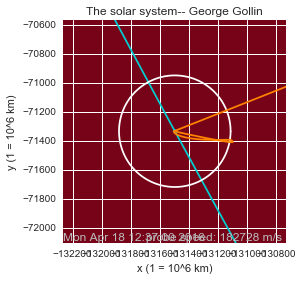

In [46]:
Start1(86400*3)

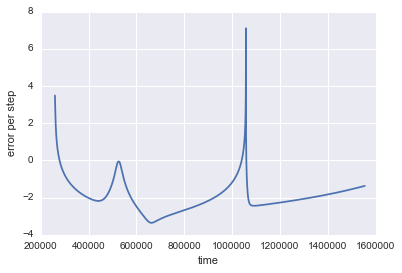

In [48]:
########## Calculating absolute differences and make plot
dt=60
deltax=[]
deltay=[]

for i in range(1,len(T)-1):
    deltax=np.append(deltax,(Vx[i-1]-2*Vx[i]+Vx[i+1])*dt)
    deltay=np.append(deltay,(Vy[i-1]-2*Vy[i]+Vy[i+1])*dt)
delta=np.sqrt(deltax**2+deltay**2)
pt.plot(T[1:len(T)-1],np.log10(delta))
pt.xlabel('time')
pt.ylabel('error per step')
pt.show()

<font size=4>Time took: Problem 1: 30 minutes. Problem 2: 1 hour. Collaborator: Completed on my own. Reference: None. <font>